In [50]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as f
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
# matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [51]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])


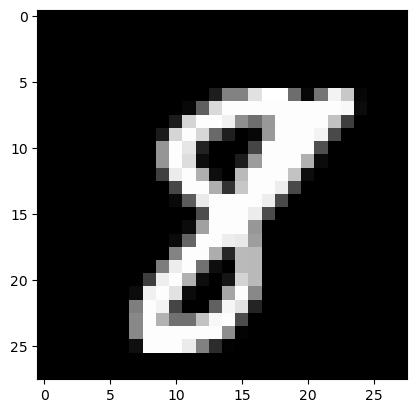

In [52]:
image, label = dataset[55]
print('image.shape:', image.shape)
# However, plt.imshow expects channels to be last dimension in an image tensor, so we use the permute method to reorder the dimensions of the image
# 0,1,2 are the indices of dimensions of an image tensor
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.show()

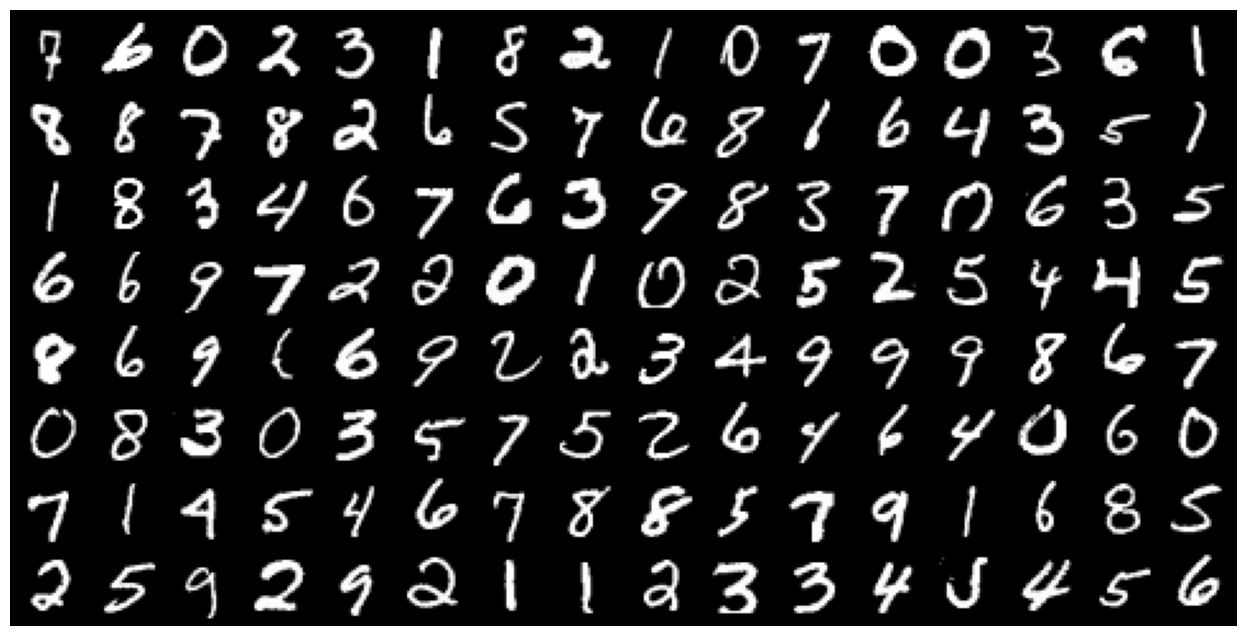

In [53]:
val_size = 10000
train_size = len(dataset)-val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 128
# num_workers parameter specifies the number of subprocesses to use for data loading. By default, it is set to 0, which means the main process loads the data.
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3)
val_dl = DataLoader(val_ds, 2*batch_size, num_workers=3)

for images, _ in train_dl:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    plt.show()
    break

In [54]:
for images, _ in train_dl:
    inputs = images.reshape(-1,784)
    break

In [55]:
# input_size means number of features
# output_size is the number of predicted outputs, here it is 30
input_size = inputs.shape[-1] # -1 refers to the last dimension, here it is 784
hidden_size = 30
layer1 = nn.Linear(input_size, hidden_size) # This is the hidden layer
layer1_outputs = layer1(inputs)
layer1_outputs.shape

torch.Size([128, 30])

In [56]:
# We refer to ReLU as the activation function, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)
relu_outputs = f.relu(layer1_outputs)

# How neural net works?
In above example, each input means 128 images. By each image, we mean 784 pixels. This 784 pixels are then linearly transformed (using linear model) and give some 30 output values. 
Now, this thing is done in batches of size 128, simple, that's it!
Basically, the output sum is a weighted sum of elements of input matrix
# What about activation function like ReLU?
For each input, that is for each 128 x 784 input matrix, we get a 128 x 30 matrix but only certain outputs are activated (those with non-zero values) while others turned off (those with zero values).
So we say that only some outputs from the 30 output values are activated.
An activation function follows a layer

In [57]:
# Now getting a vector of size 10 (as we want 10 sized vector for our 10 digits)
# So we apply one more layer which will also have some transformation
output_size = 10
layer2 = nn.Linear(hidden_size,output_size) # Now my input_size for layer2 becomes the output_size for layer1 which was 30
layer2_outputs = layer2(relu_outputs) # Now inside the model, we feed the output layer of layer1 (after applying activation fucntion on it) as the input layer for layer2
layer2_outputs.shape

torch.Size([128, 10])

In [58]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size,hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size,out_size)

    def forward(self,xb):
        xb = xb.view(xb.size(0),-1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = f.cross_entropy(out, labels)
        return loss

    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = f.cross_entropy(out, labels)
        acc = accuracy(out, labels) 
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()} # return dictionary

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [59]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [60]:
input_size = 784
hidden_size = 32 
num_classes = 10
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [61]:
for t in model.parameters(): # all the parameters associated with each layers
    print(t.shape) 

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [62]:
for images, labels in train_dl:
    outputs = model(images)
    loss = f.cross_entropy(outputs,labels)
    print('Loss:', loss.item())
    break

Loss: 2.315471649169922


In [63]:
torch.cuda.is_available()

False

In [64]:
def evaluate(model, val_dl):
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, val_dl, opt_fun=torch.optim.SGD):
    history = []
    optimizer = opt_fun(model.parameters(),lr)
    for epoch in range(epochs):
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model,val_dl)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [68]:
history = fit(10,0.1,model,train_dl,val_dl)

Epoch [0], val_loss: 0.2863, val_acc: 0.9255
Epoch [1], val_loss: 0.2849, val_acc: 0.9245
Epoch [2], val_loss: 0.2851, val_acc: 0.9251
Epoch [3], val_loss: 0.2827, val_acc: 0.9276
Epoch [4], val_loss: 0.2853, val_acc: 0.9262
Epoch [5], val_loss: 0.2854, val_acc: 0.9258
Epoch [6], val_loss: 0.2848, val_acc: 0.9268
Epoch [7], val_loss: 0.2856, val_acc: 0.9272
Epoch [8], val_loss: 0.3004, val_acc: 0.9195
Epoch [9], val_loss: 0.2869, val_acc: 0.9250
